# Sistema de recomendação
A partir do perfil dos clientes que já realizaram compras na feira, serão criados grupos de perfis de clientes com base nos produtos comprados. Esses grupos poderão ser então utilizados para realização de recomendações de produtos a serem sugeridas ao longo do processo de compra em pedidos futuros, classificando-se o cliente em algum dos grupos de perfil e sugerindo-se produtos deste grupo ao cliente.<p>
Inicialmente faremos o agrupamento dos clientes utilizando K-Means, dada sua boa performance para grande quantidade de dados quando comparado a outras opções como, por exemplo, Hierarchical Clustering. DBSCAN foi descartado pois sua detecção de outliers traria complicações indesejadas.

In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,confusion_matrix,ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier
import joblib

Dentre os data sets que temos disponíveis, o mais apropriado para esta situação é o que contém informações de pedidos em formato wide.

In [2]:
df = pd.read_csv('arquivos/pedidos_wide_final.csv')
df.head()

,id_pedido,data_pedido,hora_pedido,id_cliente,bairro_pedido,cidade_pedido,cep_pedido,tipo_pagamento,agente,i_agua de coco,...,vl_tot_pimentao [ 500g ],i_abobrinha,qt_abobrinha,vl_tot_abobrinha,i_quiabo [ kg ],qt_quiabo [ kg ],vl_tot_quiabo [ kg ],i_pepino amarelo [ unidade ],qt_pepino amarelo [ unidade ],vl_tot_pepino amarelo [ unidade ]
0,54,2020-07-03,11:30:53,39,aldeota,fortaleza,60150060,Pagar ao retirar na loja,android,True,...,0.0,False,0.0,0.0,False,0.0,0.0,False,0.0,0.0
1,56,2020-07-03,11:32:27,38,sao gerardo,fortaleza,60320105,Cartão de Crédito,windows,False,...,0.0,False,0.0,0.0,False,0.0,0.0,False,0.0,0.0
2,59,2020-07-03,11:38:01,35,manoel satiro,fortaleza,60713480,Cartão de Crédito,windows,False,...,0.0,False,0.0,0.0,False,0.0,0.0,False,0.0,0.0
3,60,2020-07-03,11:38:27,33,rodolfo teofilo,fortaleza,60431075,Débito/Transferência,android,True,...,0.0,False,0.0,0.0,False,0.0,0.0,False,0.0,0.0
4,64,2020-07-03,11:49:13,40,rodolfo teofilo,fortaleza,60430660,Cartão de Crédito,android,False,...,0.0,False,0.0,0.0,False,0.0,0.0,False,0.0,0.0


## Criação dos grupos de clientes com K-Means
Optaremos por utilizar a quantidade de cada produto comprada pelos clientes, dado que tal informação nos traz conhecimento mais aprofundado sobre os clientes. Há mais informação em saber que um cliente comprou dez garrafas de cajuína do que simplesmente saber que ele comprou cajuína, por exemplo, já que um cliente que comprou sete garrafas está mais próximo de um outro que comprou dez do que um terceiro que comprou somente uma.

In [3]:
# Selecionando as colunas de interesse: as que contém quantidade de itens por produtos
cols_int = [col for col in df.columns if 'qt_' in col and col != 'qt_final_itens']

X = df[cols_int]
scaler = StandardScaler()
scaled_X = scaler.fit_transform(X)

A escolha da quantidade de grupos se dará por meio do método do cotovelo. Testaremos diversos valores para K (quantidade de clusters) e verificaremos a clareza na separação dos grupos. A forma de quantificar esta clareza é através da medição da soma do quadrado das distâncias (SSD) de cada ponto para o centro de seu cluster. Enquanto o aumento de K estiver resultando em decréscimo significativo de SSD, continuaremos aumentando K. Quando este decréscimo reduzir, não mais vale a pena aumentar K. Testaremos valores de K entre 2 e 200.

In [4]:
ssd = list()

for k in range(2,200):
    modelo_kmeans = KMeans(n_clusters=k)
    modelo_kmeans.fit(scaled_X)
    
    ssd.append(modelo_kmeans.inertia_) # Aqui está SSD.

Vamos visualizar graficamente o progresso do valor de SSD conforme K foi aumentado e procurar pelo cotovelo que demonstra queda inexpressiva de SSD para descobrirmos o melhor valor para K.

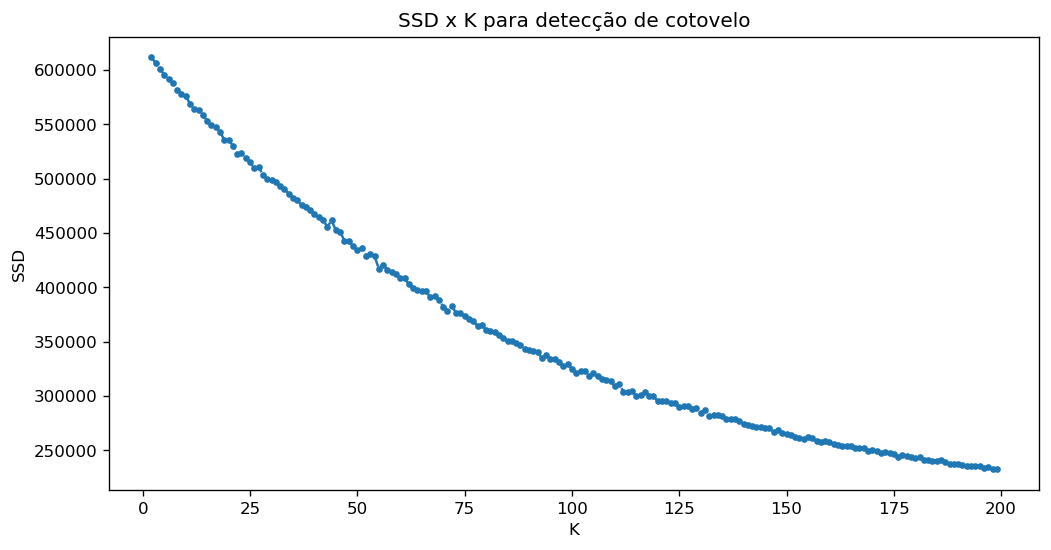

In [5]:
plt.figure(dpi=120,figsize=(10,5))
plt.xlabel('K')
plt.ylabel('SSD')
plt.title('SSD x K para detecção de cotovelo')
plt.plot(range(2,200),ssd,'.--');

Como a quantidade de produtos é bastante grande, não queremos uma quantidade de clusters (K) muito pequena para evitar perfis de clientes muito genéricos. Por esta razão, ignoraremos alguns pontos onde K ainda é pequeno e SSD não reduziu significativamente com K + 1. Perceba também um cotovelo bastante interessante na área onde K está entre 25 e 50.

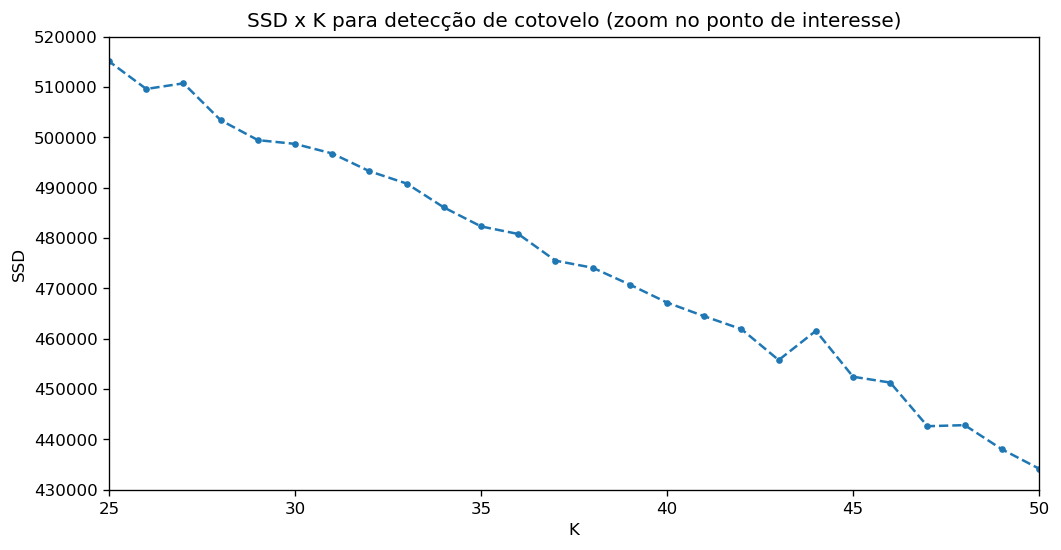

In [6]:
plt.figure(dpi=120,figsize=(10,5))
plt.xlabel('K')
plt.ylabel('SSD')
plt.title('SSD x K para detecção de cotovelo (zoom no ponto de interesse)')
plt.xlim(25,50)
plt.ylim(430000,520000)
plt.plot(range(2,200),ssd,'.--');

Podemos ver que SSD com K = 44 é maior que SSD com K = 43, portanto 43 é um bom valor para K. Vamos classificar os pedidos dentro desses 43 grupos.<p>
**Importante:** este modelo deve ser retreinado sempre que houver acréscimo ou remoção de produtos no inventário de produtos. Também deve ser retreinado com alguma frequência para levar em consideração compras mais recentes.

In [7]:
modelo_kmeans = KMeans(n_clusters=35)
labels = modelo_kmeans.fit_predict(scaled_X)
df['grupo'] = labels
X['grupo'] = labels

/tmp/ipykernel_23113/731193954.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['grupo'] = labels


Quantos pedidos temos por grupo?

In [8]:
df['grupo'].value_counts()

4     1468
23     810
12     393
8      304
24     114
19     111
1       94
13      36
32      25
20      20
25      19
6       19
18      18
16      14
0       11
21      10
5        8
22       8
34       6
30       5
26       5
2        5
3        4
27       4
15       3
9        2
7        2
14       2
28       1
33       1
29       1
31       1
17       1
10       1
11       1
Name: grupo, dtype: int64

Dada a quantidade de partâmetros que temos em X, o mapa de calor a seguir torna-se bastante difícil de ler. Mesmo assim, ele é visualizável caso aberto em outra aba pois foi gerado com resolução bastante alta. Não é possível aprender muita coisa dele, mas podemos perceber que alguns grupos tem correlação mais direta com algum produto específico. Alguns padrões de compra também são verificáveis.

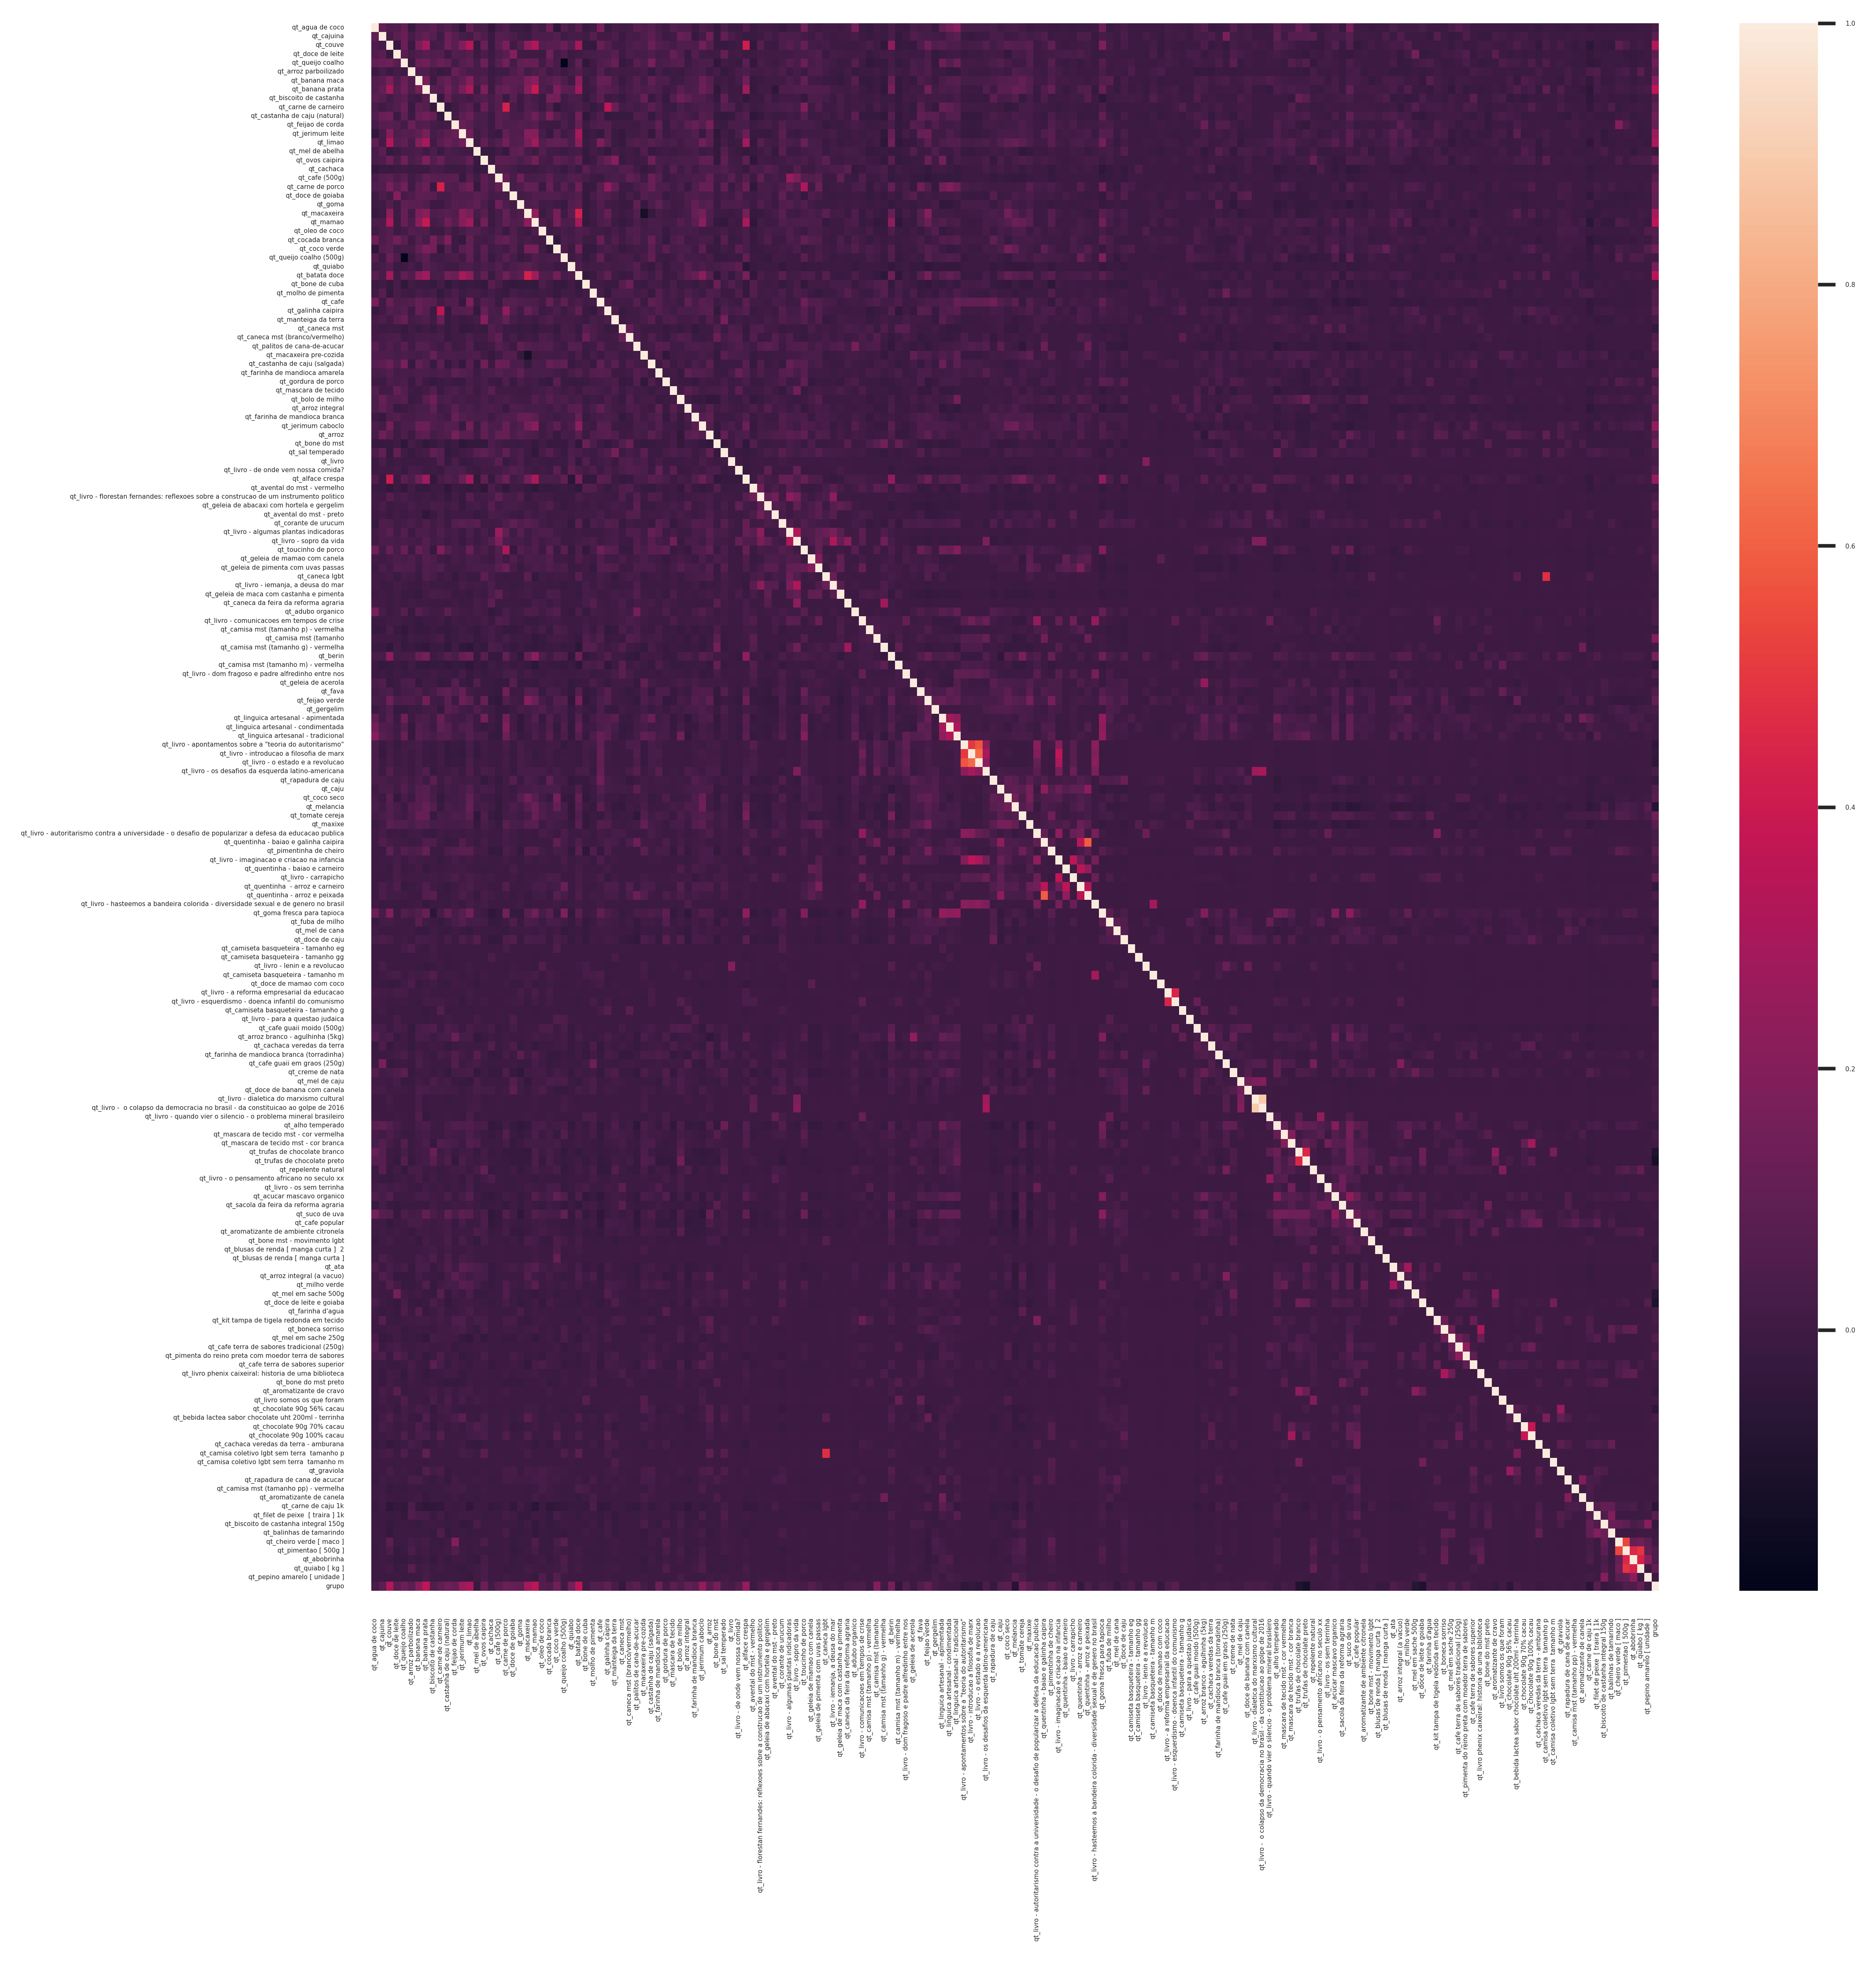

In [10]:
plt.figure(dpi=500,figsize=(10,10))
sns.set(font_scale=0.2)
sns.heatmap(X.corr());

É necessário descobrir quais os produtos mais populares para cada grupo.

In [11]:
prods_grupos = dict()

for grupo in df['grupo'].unique():
    prods_grupo = list() # Lista de produtos, do mais popular para o menos popular, onde quantidade de produtos > 0
    lista_prods = df[df['grupo'] == grupo][cols_int].sum().sort_values(ascending=False)
    
    for i in range(0,len(lista_prods)):
        if lista_prods.values[i] > 0:
            prods_grupo.append(lista_prods.index[i])
        else:
            break
            
    prods_grupos[grupo] = [prod[3:] for prod in prods_grupo]

Abaixo podemos ver um dicionário com uma lista de produtos para cada grupo, estando eles dos mais populares para os menos populares.

In [12]:
prods_grupos

{4: ['ovos caipira',
  'cajuina',
  'biscoito de castanha',
  'mel de abelha',
  'castanha de caju (natural)',
  'queijo coalho (500g)',
  'agua de coco',
  'couve',
  'banana prata',
  'queijo coalho',
  'limao',
  'castanha de caju (salgada)',
  'batata doce',
  'doce de leite',
  'macaxeira pre-cozida',
  'feijao verde',
  'mamao',
  'coco verde',
  'cocada branca',
  'carne de carneiro',
  'feijao de corda',
  'goma',
  'alface crespa',
  'galinha caipira',
  'arroz',
  'goma fresca para tapioca',
  'carne de porco',
  'adubo organico',
  'macaxeira',
  'linguica artesanal - condimentada',
  'linguica artesanal - tradicional',
  'jerimum leite',
  'carne de caju 1k',
  'manteiga da terra',
  'rapadura de caju',
  'milho verde',
  'cafe',
  'coco seco',
  'doce de goiaba',
  'linguica artesanal - apimentada',
  'sal temperado',
  'corante de urucum',
  'jerimum caboclo',
  'cachaca',
  'doce de caju',
  'banana maca',
  'geleia de acerola',
  'bone de cuba',
  'alho temperado',
  'f

Vamos validar se o produtos no dicionário estão corretos verificando os produtos mais populares do grupo 4 diretamente no DataFrame.

In [14]:
df[df['grupo'] == 4][cols_int].sum().sort_values(ascending=False)

qt_ovos caipira                                702.0
qt_cajuina                                     596.0
qt_biscoito de castanha                        569.0
qt_mel de abelha                               454.0
qt_castanha de caju (natural)                  410.0
                                               ...  
qt_livro - carrapicho                            0.0
qt_quentinha - baiao e carneiro                  0.0
qt_livro - imaginacao e criacao na infancia      0.0
qt_mel em sache 250g                             0.0
qt_pepino amarelo [ unidade ]                    0.0
Length: 176, dtype: float64

Podemos ver que o dicionário está correto.<p>
**Importante:** ao implantar em produção, esse dicionário deve ser exportado juntamente com o modelo classificador que modelaremos a seguir. O sistema da loja deverá chamar o modelo classificador para descobrir o grupo do cliente e, em seguida, consultar este dicionário para saber quais produtos recomendar, não esquecendo de ignorar produtos que já estejam no carrinho de compras. Produtos que não estiverem disponíveis em estoque também deveriam ser ignorados.

## Classificando um carrinho de compras ativo em um dos grupos
Criados os grupos, podemos treinar alguns modelos de <u>classiicação</u> e compará-los para descobrir qual conseguiria fazer melhor predição de recomendações. Testaremos alguns modelos e compararemos suas performances para decidir qual é o mais apropriado.<p>
Utilizaremos Grid Search para otimização de hiper parâmetros e Cross Validation para melhor utilização da massa para treinamento e teste. Os dados serão separados da seguinte forma:
- 80% para treinamento;
- 10% para teste;
- 10% para avaliação final do modelo.

In [15]:
# Determinando X e y
X = df[cols_int]
y = df['grupo']

# Separando a massa conforme descrito acima
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_holdout, X_test, y_holdout, y_test = train_test_split(X_test, y_test, test_size=0.5)

Vamos verificar o tamanho dos grupos para garantir que a separação se deu de forma correta.

In [16]:
print(f"Tamanho de X: {len(X)}")
print(f"Tamanho de y: {len(y)}")
print(f"Tamanho de X_train: {len(X_train)}")
print(f"Tamanho de y_train: {len(y_train)}")
print(f"Tamanho de X_test: {len(X_test)}")
print(f"Tamanho de y_test: {len(y_test)}")
print(f"Tamanho de X_holdout: {len(X_holdout)}")
print(f"Tamanho de y_holdout: {len(y_holdout)}")

Tamanho de X: 3527
Tamanho de y: 3527
Tamanho de X_train: 2821
Tamanho de y_train: 2821
Tamanho de X_test: 353
Tamanho de y_test: 353
Tamanho de X_holdout: 353
Tamanho de y_holdout: 353


Normalizando os dados.

In [17]:
scaler = StandardScaler()
scaler.fit(X_train) # Fit somente com dados de treinamento para evitar data leakage
scaled_X_train = scaler.transform(X_train)
scaled_X_test = scaler.transform(X_test)
scaled_X_holdout = scaler.transform(X_holdout)

Vamos criar uma função genérica que irá nos mostrar métricas de performance do modelos que testaremos.

In [18]:
def reportar(model):
    y_pred = model.predict(scaled_X_test)
    print(f"Melhores parâmetros: {model.best_params_}")
    print(classification_report(y_test,y_pred))
    cm = confusion_matrix(y_test,y_pred)
    ConfusionMatrixDisplay(cm).plot()
    plt.show()
    return classification_report(y_test,y_pred)

### Regressão logística
Trata-se do modelo mais simples de classificação. Consiste de uma adaptação da regressão linear, utilizando-se de uma função sigmóide para decidir se um grupo de parâmetros pertence a uma classe (1) ou não (0). Sua performance computacional normalmente deixa a desejar quando comparada a modelos mais modernos.<p>
Testaremos a aplicação das técnicas de redução de complexidade ridge (l1) e lasso (l2), assim como elasticnet, que é uma mistura das duas, tentando atingir a melhor performance do modelo. O emprego dessas técnicas diminui a chance de overfitting ocorrer Serão mostradas algumas mensagens de warning porque o parâmetro <code>l1_ratio</code>, que determina a quantidade de ridge no elasticnet, só faz sentido quando elasticnet está sendo usado. Também testaremos alguns valores para o hiper parâmetro <code>C</code>, que determina a força da regularização. Um número máximo de iteração também será informado para diminuir os warnings devido à impossibilidade de convergência do modelo.

/home/luciano/miniconda3/envs/Pos/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/home/luciano/miniconda3/envs/Pos/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/luciano/miniconda3/envs/Pos/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/luciano/miniconda3/envs/Pos/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/luciano/miniconda3/envs/Pos/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1476: UserWarning: l1_ratio parameter is only used when pe

/home/luciano/miniconda3/envs/Pos/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/luciano/miniconda3/envs/Pos/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/luciano/miniconda3/envs/Pos/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/luciano/miniconda3/envs/Pos/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/luciano/miniconda3/envs/Pos/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1476: UserWarning: l1_ratio parameter is only used when pena

Melhores parâmetros: {'C': 1.0, 'l1_ratio': 0.0, 'max_iter': 1000, 'penalty': 'l2'}
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      0.70      0.82        10
           2       1.00      1.00      1.00         1
           3       0.00      0.00      0.00         1
           4       0.98      0.98      0.98       146
           6       1.00      1.00      1.00         1
           8       0.97      0.95      0.96        38
           9       0.00      0.00      0.00         1
          12       0.86      0.97      0.91        33
          13       1.00      0.80      0.89         5
          16       1.00      0.67      0.80         3
          18       1.00      0.50      0.67         2
          19       1.00      1.00      1.00         8
          21       1.00      1.00      1.00         1
          23       0.90      0.98      0.94        84
          24       0.78      0.64      0.70        

/home/luciano/miniconda3/envs/Pos/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/luciano/miniconda3/envs/Pos/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/luciano/miniconda3/envs/Pos/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

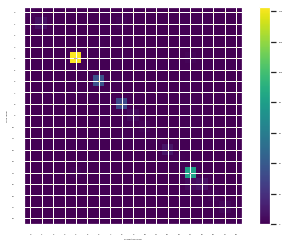

/home/luciano/miniconda3/envs/Pos/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/luciano/miniconda3/envs/Pos/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/luciano/miniconda3/envs/Pos/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

In [19]:
modelo_log = LogisticRegression()

penalty = ['l1','l2','elasticnet'] # 3 técnicnas de redução de complexidade
l1_ratio = np.linspace(0,1,3) # 3 valores de l1_ratio
C = np.logspace(0,10,5) # 5 valores de C
max_iter = [1000]
param_grid = {'penalty':penalty,'l1_ratio':l1_ratio,'C':C,'max_iter':max_iter}

modelo_grid_log = GridSearchCV(modelo_log,param_grid=param_grid)
modelo_grid_log.fit(scaled_X_train,y_train)
cr_log = reportar(modelo_grid_log)

### Support vector machines
Basicamente, SVM separa pontos em um plano cartesiano multidimensional com hiper planos. Esta separação define as classes. Os dados são projetados em uma quantidade maior de dimensões, o que permite que separações que não são possíveis na quantidade "normal" de dimensões sejam realizadas. Um classificador de tamanho de margem pode ser determinado para definir uma tolerância de existência de pontos de uma classe em uma partição que não é a da sua classe. Há diversos kernels, cada um se aproximando do problema de forma distinta. Testaremos algumas das possíveis combinações com Grid Search.

/home/luciano/miniconda3/envs/Pos/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Melhores parâmetros: {'C': 0.1, 'degree': 2, 'gamma': 'scale', 'kernel': 'linear'}
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      0.80      0.89        10
           2       1.00      1.00      1.00         1
           3       1.00      1.00      1.00         1
           4       0.97      0.97      0.97       146
           6       1.00      1.00      1.00         1
           8       0.93      0.97      0.95        38
           9       1.00      1.00      1.00         1
          12       0.88      0.85      0.86        33
          13       0.83      1.00      0.91         5
          16       1.00      0.67      0.80         3
          18       1.00      1.00      1.00         2
          19       1.00      1.00      1.00         8
          21       1.00      1.00      1.00         1
          23       0.91      0.94      0.92        84
          24       0.88      0.64      0.74        1

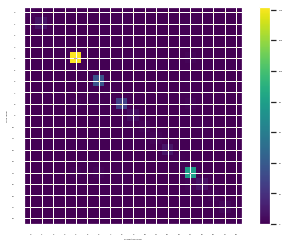

In [20]:
modelo_svm = SVC()

C = [0.001,0.01,0.1,0.5,1]
kernel = ['linear','rbf','poly']
gamma = ['scale','auto']
degree = [2,3,4]
param_grid = {'C':C,'kernel':kernel,'gamma':gamma,'degree':degree}

modelo_grid_svm = GridSearchCV(modelo_svm,param_grid=param_grid)
modelo_grid_svm.fit(scaled_X_train,y_train)
cr_svm = reportar(modelo_grid_svm)

### Random forests
Random forests possuem a habilidade de aumentar consideravelmente a performance de modelos que baseiam árvores de decisão. Trata-se de um ensemble learner por utilizar-se de um conjunto de decisores para realizar predições. São criadas diversas árvores, cada uma analisando um subgrupo de parâmetros. A predição é feita por meio de contagem dos votos das várias árvores. A classe com mais votos é selecionada. No caso de regressões, onde o label é contínuo, o resultando é uma média da predição de cada árvore.<p>
Os hiper parâmetros que testaremos com Grid Search serão a quantidade e árvores a serem criadas (n_estimators, a quantidade máxima de parâmetros por árvore (max_features) e a utilização de bootstrap. Bootstraping nada mais é do que a seleção de algumas linhas, ao invés de todas, para treinamento de cada árvore. Permite que as árvores sejam mais diversificadas.<p>
Dadas todas essas aleatoriedades na seleção de linhas e colunas a serem usadas para testar cada árvore, Random Forests não corre o risco de sofrer overfitting.

/home/luciano/miniconda3/envs/Pos/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Melhores parâmetros: {'bootstrap': False, 'max_features': 10, 'n_estimators': 250}
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       1.00      0.50      0.67        10
           2       0.00      0.00      0.00         1
           3       0.00      0.00      0.00         1
           4       0.79      0.99      0.88       146
           6       0.00      0.00      0.00         1
           8       0.90      0.95      0.92        38
           9       0.00      0.00      0.00         1
          12       0.86      0.36      0.51        33
          13       0.00      0.00      0.00         5
          16       1.00      0.33      0.50         3
          18       1.00      0.50      0.67         2
          19       0.80      1.00      0.89         8
          21       1.00      1.00      1.00         1
          23       0.77      0.83      0.80        84
          24       0.75      0.27      0.40        1

/home/luciano/miniconda3/envs/Pos/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/luciano/miniconda3/envs/Pos/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/luciano/miniconda3/envs/Pos/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

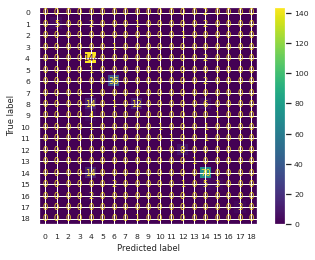

/home/luciano/miniconda3/envs/Pos/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/luciano/miniconda3/envs/Pos/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/luciano/miniconda3/envs/Pos/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

In [42]:
modelo_rf = RandomForestClassifier()

n_estimators = [200,250,300]
max_features = [5,10,50,100,150]
bootstrap = [True,False]
param_grid = {'n_estimators':n_estimators,'max_features':max_features,'bootstrap':bootstrap}

modelo_grid_rf = GridSearchCV(modelo_rf,param_grid=param_grid)
modelo_grid_rf.fit(scaled_X_train,y_train)
cr_rf = reportar(modelo_grid_rf)

### AdaBoost
Não se trata de um algortimo de ML, mas sim de uma metodologia. Por esta razão, é chamado de meta learning.<p>
Adaptative boosting, ou AdaBoost, cria um grupo de estimadores fracos e os combina por meio de soma ponderada. Se adapta utilizando estimadores fracos previamente criados para ajustar erros de classificação em estimadores posteriores. Apesar de poder ser utilizado com qualquer algoritmo de ML, normalmente é utilizado com árvore de classificação, criando simples *stumps*, que nada mais são do que árvores de decisão com somente um nó raíz e duas folhas.<p>
Ao contrário de Random Forests, corre o risco de overfitting, entretanto são necessárias muitas árvores para que isso ocorra. Normalmente o erro já foi estabilizado antes de árvores suficientes para ocorrência de overfitting serem adicionadas.<p>
Testaremos com Grid Search qual a melhor quantidade de estimadores (n_estimators).

/home/luciano/miniconda3/envs/Pos/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Melhores parâmetros: {'n_estimators': 400}
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       0.00      0.00      0.00        10
           2       0.00      0.00      0.00         1
           3       1.00      1.00      1.00         1
           4       0.48      1.00      0.65       146
           6       1.00      1.00      1.00         1
           8       0.86      0.95      0.90        38
           9       1.00      1.00      1.00         1
          12       0.00      0.00      0.00        33
          13       0.00      0.00      0.00         5
          16       1.00      0.67      0.80         3
          18       0.00      0.00      0.00         2
          19       0.00      0.00      0.00         8
          21       0.00      0.00      0.00         1
          23       0.00      0.00      0.00        84
          24       0.00      0.00      0.00        11
          25       0.00      0.00     

/home/luciano/miniconda3/envs/Pos/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/luciano/miniconda3/envs/Pos/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/luciano/miniconda3/envs/Pos/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

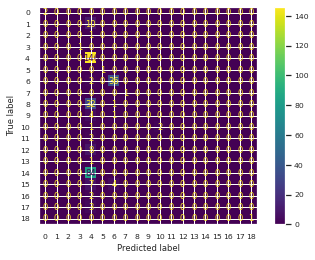

/home/luciano/miniconda3/envs/Pos/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/luciano/miniconda3/envs/Pos/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/luciano/miniconda3/envs/Pos/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

In [45]:
modelo_ab = AdaBoostClassifier()

n_estimators = [200,250,300,350,400,450,500]
param_grid = {'n_estimators':n_estimators}

modelo_grid_ab = GridSearchCV(modelo_ab,param_grid=param_grid)
modelo_grid_ab.fit(scaled_X_train,y_train)
cr_ab = reportar(modelo_grid_ab)

### Comparando os modelos.
Vamos compilar e verificar graficamente os valores dos relatórios de classificação reportados demonstrado acima para comparar a performance dos modelos.

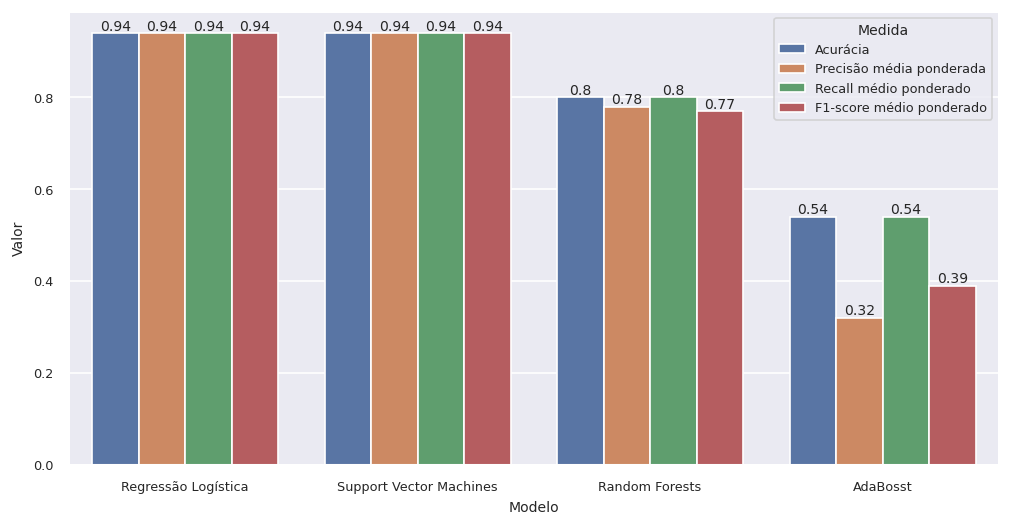

In [46]:
resultados = {'Modelo':['Regressão Logística','Support Vector Machines','Random Forests','AdaBosst'],
             'Acurácia':[cr_log[1121:1125],cr_svm[1121:1125],cr_rf[1121:1125],cr_ab[1121:1125]],
             'Precisão média ponderada':[cr_log[1209:1213],cr_svm[1209:1213],cr_rf[1209:1213],cr_ab[1209:1213]],
             'Recall médio ponderado':[cr_log[1219:1223],cr_svm[1219:1223],cr_rf[1219:1223],cr_ab[1219:1223]],
             'F1-score médio ponderado':[cr_log[1229:1233],cr_svm[1229:1233],cr_rf[1229:1233],cr_ab[1229:1233]]}

df_res = pd.DataFrame(resultados)
df_res['Acurácia'] = pd.to_numeric(df_res['Acurácia'])
df_res['Precisão média ponderada'] = pd.to_numeric(df_res['Precisão média ponderada'])
df_res['Recall médio ponderado'] = pd.to_numeric(df_res['Recall médio ponderado'])
df_res['F1-score médio ponderado'] = pd.to_numeric(df_res['F1-score médio ponderado'])

df_res = pd.melt(df_res, id_vars='Modelo',var_name="Medida",value_name="Valor")

plt.figure(dpi=120,figsize=(10,5))
ax = sns.barplot(data=df_res,x='Modelo',y='Valor',hue='Medida')
sns.set(font_scale=0.7)

for i in range(4):
    ax.bar_label(ax.containers[i])

plt.show()

É possível perceber que a regressão logística e o modelo SVM tiveram performances similares. Dada sua melhor performance computacional, optaremos pela utilização do modelo SVM. Vamos calcular a performance final do modelo usando a massa de avaliação final.<p>
Os hiper parâmetros serão populados com os melhores valores reportados pelo Grid Search do modelo SVM.

In [54]:
y_pred = modelo_grid_svm.predict(scaled_X_holdout)
print(classification_report(y_holdout,y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       0.92      1.00      0.96        11
           4       0.96      0.98      0.97       133
           5       1.00      1.00      1.00         2
           6       1.00      1.00      1.00         1
           7       1.00      1.00      1.00         1
           8       1.00      1.00      1.00        24
          11       0.00      0.00      0.00         1
          12       0.88      0.93      0.90        40
          13       1.00      0.50      0.67         2
          14       0.00      0.00      0.00         1
          15       1.00      1.00      1.00         1
          16       1.00      1.00      1.00         2
          18       1.00      1.00      1.00         2
          19       1.00      1.00      1.00        13
          20       1.00      1.00      1.00         4
          21       1.00      1.00      1.00         1
          22       0.00    

/home/luciano/miniconda3/envs/Pos/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/luciano/miniconda3/envs/Pos/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/luciano/miniconda3/envs/Pos/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/

Acurácia, assim como precisão, recall e f1-score médios ficaram com 0,95.

## Exportando o modelo classificador escolhido
Além do modelo, vamos exportar o scaler e o dicionário de produtos. O modelo SVM será retreinado com toda a massa de dados.

In [58]:
modelo_classificador_final = SVC(C=0.1,degree=2,gamma='scale',kernel='linear')

X = df[cols_int]
y = df['grupo']

scaled_X = scaler.fit_transform(X)

modelo_classificador_final.fit(scaled_X,y)

joblib.dump(modelo_classificador_final,'arquivos/modelos/modelo_svm_recomendacao.pkl')
joblib.dump(scaler,'arquivos/modelos/scaler_recomendacao.pkl')
joblib.dump(prods_grupos,'arquivos/modelos/dicionario_produtos_classificacao.pkl');

## Testando o modelo exportado
Vamos importar os objetos exportados em novas variáveis e testá-los, simulando uma recomendação de produto. Usaremos um dos pedidos presentes no DataFrame de pedidos para fazer esta simulação.

In [74]:
# Carregando os objetos necessários à classificação.
loaded_model = joblib.load('arquivos/modelos/modelo_svm_recomendacao.pkl')
loaded_scaler = joblib.load('arquivos/modelos/scaler_recomendacao.pkl')
loaded_dic_prods = joblib.load('arquivos/modelos/dicionario_produtos_classificacao.pkl')

# Lendo um pedido e normalizando seus dados.
scaled_sim_X = loaded_scaler.transform(df.iloc[[0]][cols_int])

y_sim = loaded_model.predict(scaled_sim_X)

print(f"O pedido se enquandra no perfil {y_sim[0]}.")

O pedido se enquandra no perfil 4.


Vejamos a lista de recomendação para clientes com o perfil 4.

In [75]:
loaded_dic_prods[4]

['ovos caipira',
 'cajuina',
 'biscoito de castanha',
 'mel de abelha',
 'castanha de caju (natural)',
 'queijo coalho (500g)',
 'agua de coco',
 'couve',
 'banana prata',
 'queijo coalho',
 'limao',
 'castanha de caju (salgada)',
 'batata doce',
 'doce de leite',
 'macaxeira pre-cozida',
 'feijao verde',
 'mamao',
 'coco verde',
 'cocada branca',
 'carne de carneiro',
 'feijao de corda',
 'goma',
 'alface crespa',
 'galinha caipira',
 'arroz',
 'goma fresca para tapioca',
 'carne de porco',
 'adubo organico',
 'macaxeira',
 'linguica artesanal - condimentada',
 'linguica artesanal - tradicional',
 'jerimum leite',
 'carne de caju 1k',
 'manteiga da terra',
 'rapadura de caju',
 'milho verde',
 'cafe',
 'coco seco',
 'doce de goiaba',
 'linguica artesanal - apimentada',
 'sal temperado',
 'corante de urucum',
 'jerimum caboclo',
 'cachaca',
 'doce de caju',
 'banana maca',
 'geleia de acerola',
 'bone de cuba',
 'alho temperado',
 'farinha de mandioca branca',
 'fava',
 'arroz integral

Por fim, vamos ver se os três produtos iniciais da lista estão presentes no carrinho de compras do pedido.

In [85]:
df.iloc[[0]][['qt_ovos caipira','qt_cajuina','qt_biscoito de castanha']]

,qt_ovos caipira,qt_cajuina,qt_biscoito de castanha
0,0.0,3.0,0.0


É possível perceber que somente o segundo produto está no carrinho do pedido. Deveria ser recomendado, portanto o produto "ovos caipira".